<Axes: >

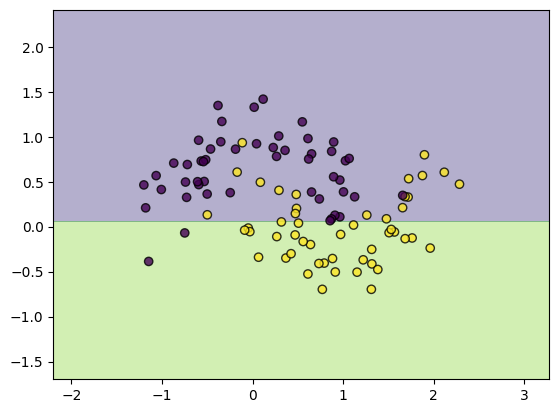

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
tree = DecisionTreeClassifier(max_depth=1)

def plot_boundary(classifier, X):
    import matplotlib.pyplot as plt
    import numpy as np
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, levels=2)
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, edgecolor='k')
    return ax

tree.fit(X, y)
plot_boundary(tree, X)

Feature: 1, Threshold: 0.05957486666738987


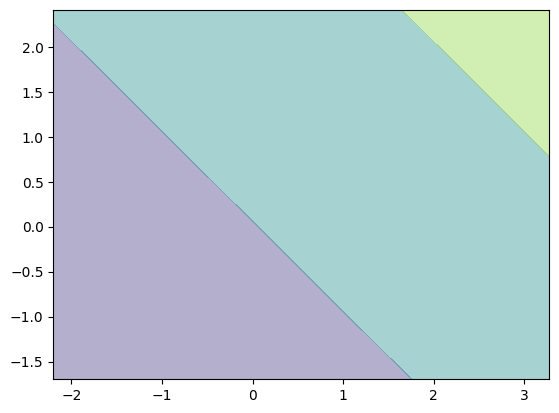

In [33]:
# For max depth 1, can we write an mlp?

feature = tree.tree_.feature[0]
threshold = tree.tree_.threshold[0]

print(f"Feature: {feature}, Threshold: {threshold}")

W_in = np.zeros((2, 1))
W_in[feature] = 1
b_in = np.array([[-threshold]])


x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01), np.arange(y_min, y_max, .01))
plt.contourf(xx, yy, xx + W_in[1] * yy + b_in, alpha=0.4, levels=2)

In [34]:
xx @ W_in + b_in

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 549)

In [36]:
xx.shape

(412, 549)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


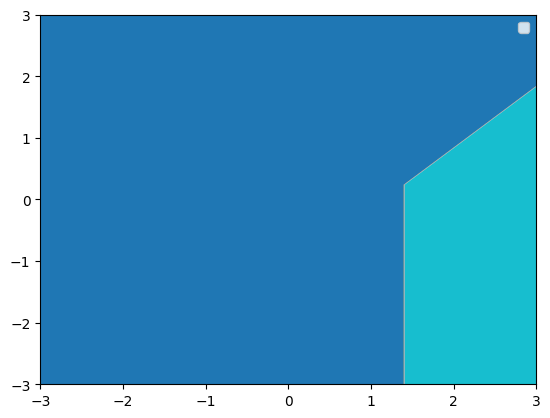

In [68]:
# Plot the decision boundaries of a random neural network
import torch
import matplotlib.pyplot as plt
import numpy as np

MAX_DEPTH = 2
N_SPLITS = 2 ** MAX_DEPTH - 1

# X = torch.randn(100, 2)

W1 = torch.randn(2, N_SPLITS)
W1 /= W1.norm(dim=0)
# Make column vectors of W1 one-hot
W1 = (W1 == W1.max(dim=0, keepdim=True).values).float()
# b1 = torch.zeros(8)
b1 = torch.randn(N_SPLITS)

# y_est = torch.relu(X @ W1 + b1).argmax(dim=1)

xx = np.linspace(-3, 3, 401)
yy = np.linspace(-3, 3, 401)
xx, yy = np.meshgrid(xx, yy)

# Map from all 2^8 possible (active/inactive) combinations of W1 to the output
splits = [1, 2, 2]
splits2region = [
    [ 1,  1,  0], # LL
    [ 1, -1,  0], # LR
    [-1,  0,  1], # RL
    [-1,  0, -1] # RR
]
region2class = [0, 1, 2, 3]

W2 = torch.tensor(splits2region, dtype=torch.float32).T

X = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
y = torch.relu(X @ W1 + b1).argmax(dim=1)
# y = (torch.relu(X @ W1 + b1) @ W2).argmax(dim=1)

plt.contourf(xx, yy, y.view(401, 401), levels=8, cmap='tab10', antialiased=True)
plt.legend()

In [53]:
W2.shape

torch.Size([4, 3])

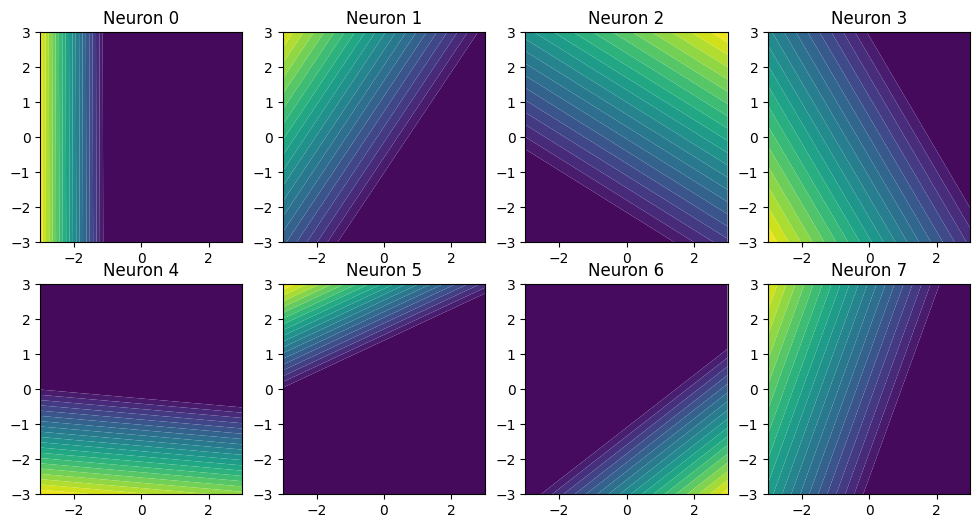

In [22]:
# Plot the activations of each neuron as well

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axs.ravel()):
    ax.contourf(xx, yy, torch.relu(X @ W1[:, i] + b1[i]).view(401, 401), levels=20, cmap='viridis', antialiased=True)
    ax.set_title(f"Neuron {i}")

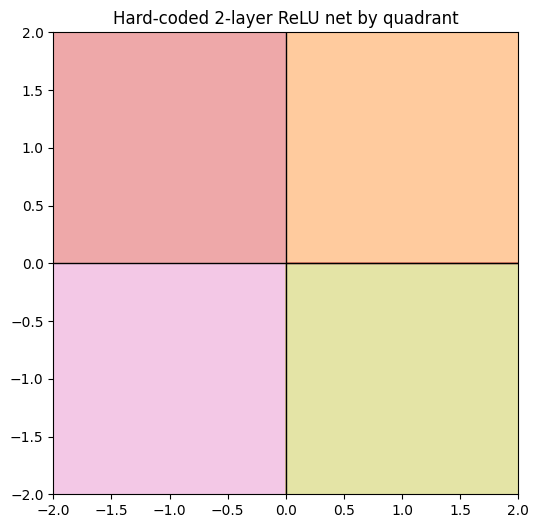

In [13]:
import numpy as np
import matplotlib.pyplot as plt

############################################
# Define the two-layer ReLU net in Wx+b form
############################################

W1 = np.array([
    [ 1.,  0.],   # => z1 = x1
    [-1.,  0.],   # => z2 = -x1
    [ 0.,  1.],   # => z3 = x2
    [ 0., -1.]])  # => z4 = -x2
b1 = np.zeros(4)

W2 = np.array([
    [1., 0., 1., 0.],  # => z_1 = h1 + h3
    [0., 1., 1., 0.],  # => z_2 = h2 + h3
    [0., 1., 0., 1.],  # => z_3 = h2 + h4
    [1., 0., 0., 1.]]) # => z_4 = h1 + h4
b2 = np.zeros(4)

def relu(x):
    return np.maximum(0, x)

def forward_net(X):
    """
    X: shape (N,2).
    Returns logits: shape (N,4).
    """
    # Layer 1
    z1 = X @ W1.T + b1  # shape (N,4)
    h1 = relu(z1)

    # Layer 2
    z2 = h1 @ W2.T + b2 # shape (N,4)
    return z2

def predict_net(X):
    z2 = forward_net(X)
    return np.argmax(z2, axis=1)

############################################
# Plot the decision regions in [-2,2]^2
############################################
grid_x = np.linspace(-2, 2, 200)
grid_y = np.linspace(-2, 2, 200)
xx, yy = np.meshgrid(grid_x, grid_y)
xy_grid = np.c_[xx.ravel(), yy.ravel()]

labels = predict_net(xy_grid).reshape(xx.shape)

fig, ax = plt.subplots(figsize=(6,6))
ax.contourf(xx, yy, labels, alpha=0.4, levels=[-0.5,0.5,1.5,2.5,3.5], cmap=plt.cm.tab10)
ax.axhline(0, color="k", lw=1)
ax.axvline(0, color="k", lw=1)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_title("Hard-coded 2-layer ReLU net by quadrant")
plt.show()
